## Import Modules

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, add

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download adityajn105/flickr8k

 99% 1.03G/1.04G [00:08<00:00, 134MB/s] 
100% 1.04G/1.04G [00:08<00:00, 130MB/s]


In [ ]:
! unzip flickr8k

In [ ]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/content/working'

## Extract Image Features

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarise
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
print(os.listdir('/content/Images'))

['2291511815_ac083fddbd.jpg', '2862469183_a4334b904a.jpg', '2318659263_c24005a5cb.jpg', '292780636_72e1968949.jpg', '494221578_027f51cdf4.jpg', '2860202109_97b2b22652.jpg', '2720215226_5a98ff2bd3.jpg', '2918769188_565dd48060.jpg', '3016178284_ec50a09e8c.jpg', '2655183854_5852790214.jpg', '3494723363_eaa6bc563b.jpg', '3303648823_53cf750acd.jpg', '3379839396_0cd84b55f1.jpg', '3064097919_e536ab9693.jpg', '2911552402_5166bc173b.jpg', '2228167286_7089ab236a.jpg', '2081679622_6f1442367d.jpg', '2268109835_d6edbe1c2b.jpg', '2696394827_7342ced36f.jpg', '3119913014_688d4997d7.jpg', '3325497914_f9014d615b.jpg', '2561481438_447b852e4d.jpg', '3549408779_4d453db080.jpg', '3184112120_6ddcd98016.jpg', '3515451715_ac5ac04efa.jpg', '2751602672_ca5e1f6447.jpg', '3279025792_23bfd21bcc.jpg', '2228022180_9597b2a458.jpg', '3589368949_0866846949.jpg', '3053743109_a2d780c0d2.jpg', '3486324591_9f5eeb24b9.jpg', '2663248626_f000f2661d.jpg', '3562302012_0cbcd01ff9.jpg', '2862481071_86c65d46fa.jpg', '3106883334_419

In [ ]:
# extract features from images

features = {}
directory = '/content/Images'

for img_name in tqdm(os.listdir('/content/Images')):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose = 0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
with open('/content/features.pkl', 'wb') as f:
    pickle.dump(features, f)

# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join('features.pkl'), 'rb') as f: features = pickle.load(f)

## Load the Captions Data

In [ ]:
with open(os.path.join('captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the lines by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image id
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

## Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lower case
            caption = caption.lower()
            # delete special characters, digits, etc.
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocessing of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_caption = []
for key in mapping:
    for caption in mapping[key]:
        all_caption.append(caption)

In [ ]:
len(all_caption)

40455

In [ ]:
all_caption[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_caption)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_caption)
max_length

35

## Train Test Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
### This is how the whole sequence splitting works

### startseq girl going into wooden building endseq
### X                                          y
# startseq                                    girl
# startseq girl                               going
# startseq girl going                         into
# ...
# startseq girl going into wooden building    endseq

In [ ]:
# create data generator to get data in batch (avoids session crash)

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0

    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequence
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

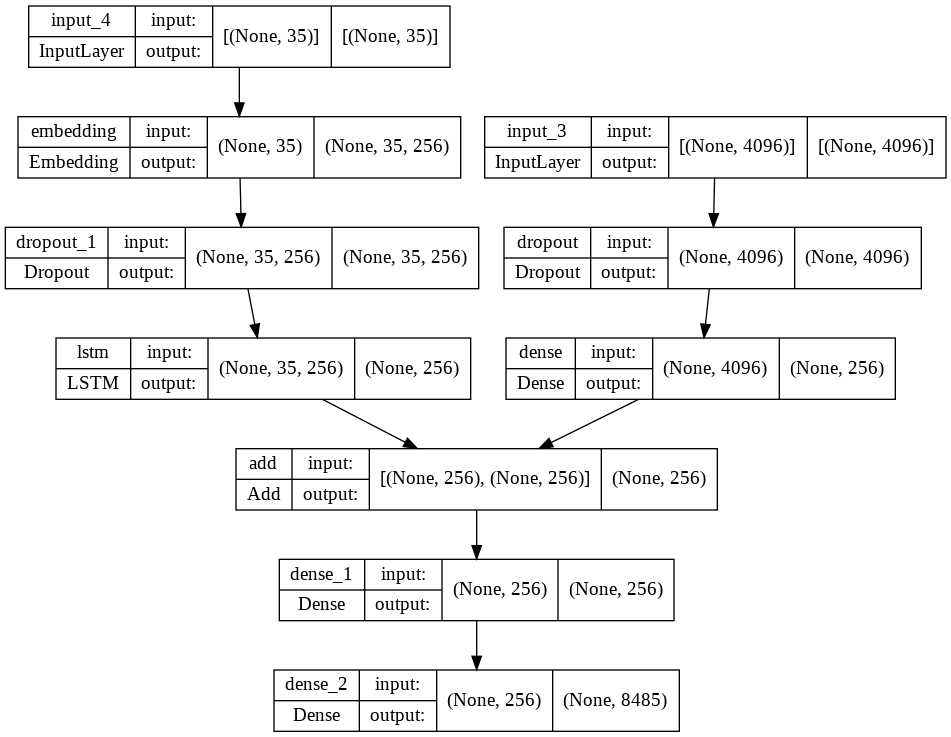

In [ ]:
# ENCODER MODEL
# image feature layers
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
input2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# DECODER MODEL
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs = 1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 45s 396ms/step - loss: 2.3167


In [ ]:
# save the model
model.save(WORKING_DIR + '/model1.h5')

## Generate Captions for the image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += ' ' + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_caption = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_caption)
    predicted.append(y_pred)

# calculate the BLEU score
print('BLEU-1: %f' %corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' %corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.557530
BLEU-2: 0.340606


## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# load the image
def generate_caption(image_name):
    image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path1 = '/content/Images/1001773457_577c3a7d70.jpg'
    #img_path2 =
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('------------------------Actual------------------------')
    for caption in captions:
        print(caption)
    print('\n')
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('------------------------Predicted------------------------')
    print(y_pred)
    print('\n')
    plt.imshow(image)

------------------------Actual------------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq


------------------------Predicted------------------------
startseq two dogs playing on the sidewalk endseq




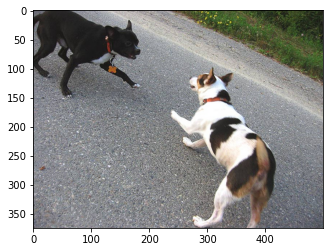

In [ ]:
generate_caption('/content/Images/1001773457_577c3a7d70.jpg')